In [1]:
import os
import evaluate
import numpy as np
from datasets import load_dataset
from transformers import (
    Trainer,
    TrainingArguments,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
)
from dataclasses import dataclass

os.environ['HTTP_PROXY'] = 'http://127.0.0.1:7890'
os.environ['HTTPS_PROXY'] = 'http://127.0.0.1:7890'

In [2]:
from sklearn.metrics import classification_report, confusion_matrix

## dataset

In [3]:
dataset = load_dataset("fancyzhx/ag_news")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [4]:
dataset["train"][0]

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.",
 'label': 2}

In [5]:
dataset["train"].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['World', 'Sports', 'Business', 'Sci/Tech'], id=None)}

In [20]:
dataset["train"].features['label'].names

['World', 'Sports', 'Business', 'Sci/Tech']

## model

> 使用英文的BERT模型

In [6]:
model_name = "bert-base-uncased"

bert = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    trust_remote_code=True,
    num_labels=4,
)

tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/jie/anaconda3/envs/d2l/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### tokenize

In [7]:
def tokenize_func(tokenizer):

    def _func(item):
        return tokenizer(
            item["text"],
            max_length=512,
            truncation=True,
        )

    return _func

In [8]:
func = tokenize_func(tokenizer=tokenizer)
func(dataset["train"][0])

{'input_ids': [101, 2813, 2358, 1012, 6468, 15020, 2067, 2046, 1996, 2304, 1006, 26665, 1007, 26665, 1011, 2460, 1011, 19041, 1010, 2813, 2395, 1005, 1055, 1040, 11101, 2989, 1032, 2316, 1997, 11087, 1011, 22330, 8713, 2015, 1010, 2024, 3773, 2665, 2153, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [9]:
new_dataset = dataset.map(tokenize_func(tokenizer=tokenizer))

## train

In [10]:
@dataclass
class BertCLS:
    def __init__(
        self,
        model,
        tokenizer,
        train_dataset=None,
        eval_dataset=None,
        output_dir="output/multi_cls/",
        epoch=3,
    ):
        self.model = model
        self.tokenizer = tokenizer
        self.train_dataset = train_dataset
        self.eval_dataset = eval_dataset

        self.data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
        self.args = self.get_args(output_dir, epoch)

    def compute_metrics(self, eval_pred):
        d = classification_report(
            eval_pred.label_ids, eval_pred.predictions.argmax(-1), output_dict=True
        )
        return d

    def get_args(self, output_dir, epoch):
        if self.eval_dataset:
            args = TrainingArguments(
                output_dir=output_dir,
                evaluation_strategy="epoch",
                save_strategy="epoch",
                save_total_limit=3,
                learning_rate=2e-5,
                num_train_epochs=epoch,
                weight_decay=0.01,
                per_device_train_batch_size=32,
                per_device_eval_batch_size=16,
                # logging_steps=16,
                save_safetensors=True,
                overwrite_output_dir=True,
                load_best_model_at_end=True,
            )

            self.trainer = Trainer(
                model=self.model,
                args=args,
                train_dataset=self.train_dataset,
                eval_dataset=self.eval_dataset,
                data_collator=self.data_collator,
                compute_metrics=self.compute_metrics,
                tokenizer=tokenizer,
            )
        else:
            args = TrainingArguments(
                output_dir=output_dir,
                evaluation_strategy="no",
                save_strategy="epoch",
                save_total_limit=3,
                learning_rate=2e-5,
                num_train_epochs=epoch,
                weight_decay=0.01,
                per_device_train_batch_size=32,
                per_device_eval_batch_size=16,
                # logging_steps=16,
                save_safetensors=True,
                overwrite_output_dir=True,
                # load_best_model_at_end=True,
            )

            self.trainer = Trainer(
                model=self.model,
                args=args,
                train_dataset=self.train_dataset,
                eval_dataset=self.eval_dataset,
                data_collator=self.data_collator,
                # compute_metrics=self.compute_metrics,
                tokenizer=tokenizer,
            )
        return args

    def set_args(self, args):
        """
        从外部重新设置 TrainingArguments，args 更新后，trainer也进行更新
        """
        self.args = args

        self.trainer = Trainer(
            model=self.model,
            args=self.args,
            train_dataset=self.train_dataset,
            eval_dataset=self.eval_dataset,
            data_collator=self.data_collator,
            # compute_metrics=compute_metrics,
            tokenizer=self.tokenizer,
        )

    def train(self, epoch=None, over_write=False):
        if epoch:
            self.args.num_train_epochs = epoch

        best_model_path = os.path.join(self.args.output_dir, "best_model")

        if over_write or not os.path.exists(best_model_path):
            self.trainer.train()
            self.trainer.save_model(best_model_path)
        else:
            print(
                f"预训练权重 {best_model_path} 已存在，且over_write={over_write}。不启动模型训练！"
            )

    def eval(self, eval_dataset):
        predictions = self.trainer.predict(eval_dataset)
        preds = np.argmax(predictions.predictions, axis=-1)
        metric = evaluate.load("glue", "mrpc")
        return metric.compute(predictions=preds, references=predictions.label_ids)

    def predict(self, pred_dataset):
        predictions = self.trainer.predict(pred_dataset)
        preds = np.argmax(predictions.predictions, axis=-1)
        return pred_dataset.add_column("pred", preds)

In [11]:
train_dataset = new_dataset["train"].train_test_split(train_size=5000)

In [12]:
bert_csl = BertCLS(
    model=bert,
    tokenizer=tokenizer,
    train_dataset=train_dataset["train"],
    eval_dataset=new_dataset["test"],
    output_dir="output/multi_cls/",
    epoch=3,
)

/home/jie/anaconda3/envs/d2l/lib/python3.11/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
bert_csl.train(5, over_write=True)

In [ ]:
pred_dataset = bert_csl.predict(new_dataset["test"])

In [16]:
print(classification_report(
    pred_dataset["label"],
    pred_dataset["pred"],
    # output_dict=True
))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92      1900
           1       0.98      0.97      0.97      1900
           2       0.87      0.88      0.88      1900
           3       0.87      0.91      0.89      1900

    accuracy                           0.91      7600
   macro avg       0.92      0.91      0.91      7600
weighted avg       0.92      0.91      0.91      7600



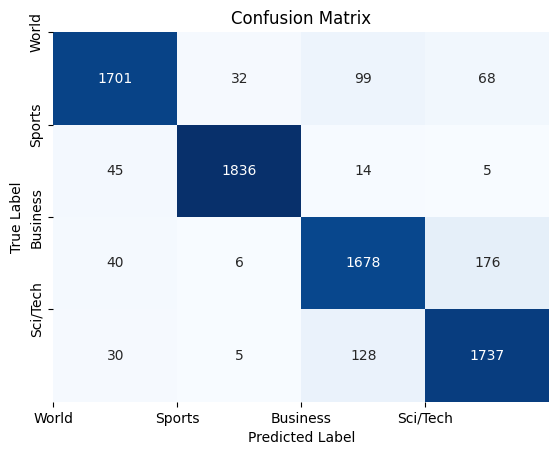

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# 绘制混淆矩阵热图
cm = confusion_matrix(
    pred_dataset["label"],
    pred_dataset["pred"],
)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(ticks=range(len(cm)), labels=dataset["train"].features['label'].names)  # 更改为你的标签
plt.yticks(ticks=range(len(cm)), labels=dataset["train"].features['label'].names)  # 更改为你的标签

plt.show()